In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

import scipy.signal as signal

In [2]:
plt.style.use('notebook')

In [3]:
tlist = []

for i in range(10):
    t = Table.read('../data/bulk/lc_{:04d}.fits'.format(i))
    tlist += [t]

In [4]:
tm = []
fm = []

for t in tlist:
    sec = np.unique(t['sector_id'])
    ind_clip = np.zeros(len(t), dtype='bool')
    for s in sec:
        ind = t['sector_id']==s
        ind_clip[ind] = np.abs(t['fcorr'][ind]/np.nanmedian(t['fcorr'][ind])-1)<0.002
#     ind_clip = np.abs(t['fcorr']/np.nanmedian(t['fcorr'])-1)<0.002
    tm += [t['t'][ind_clip]]
    fm += [t['fnorm'][ind_clip] - np.mean(t['fnorm'][ind_clip])]
    
#     tm += [t['t']]
#     fm += [t['fnorm'] - np.mean(t['fnorm'])]

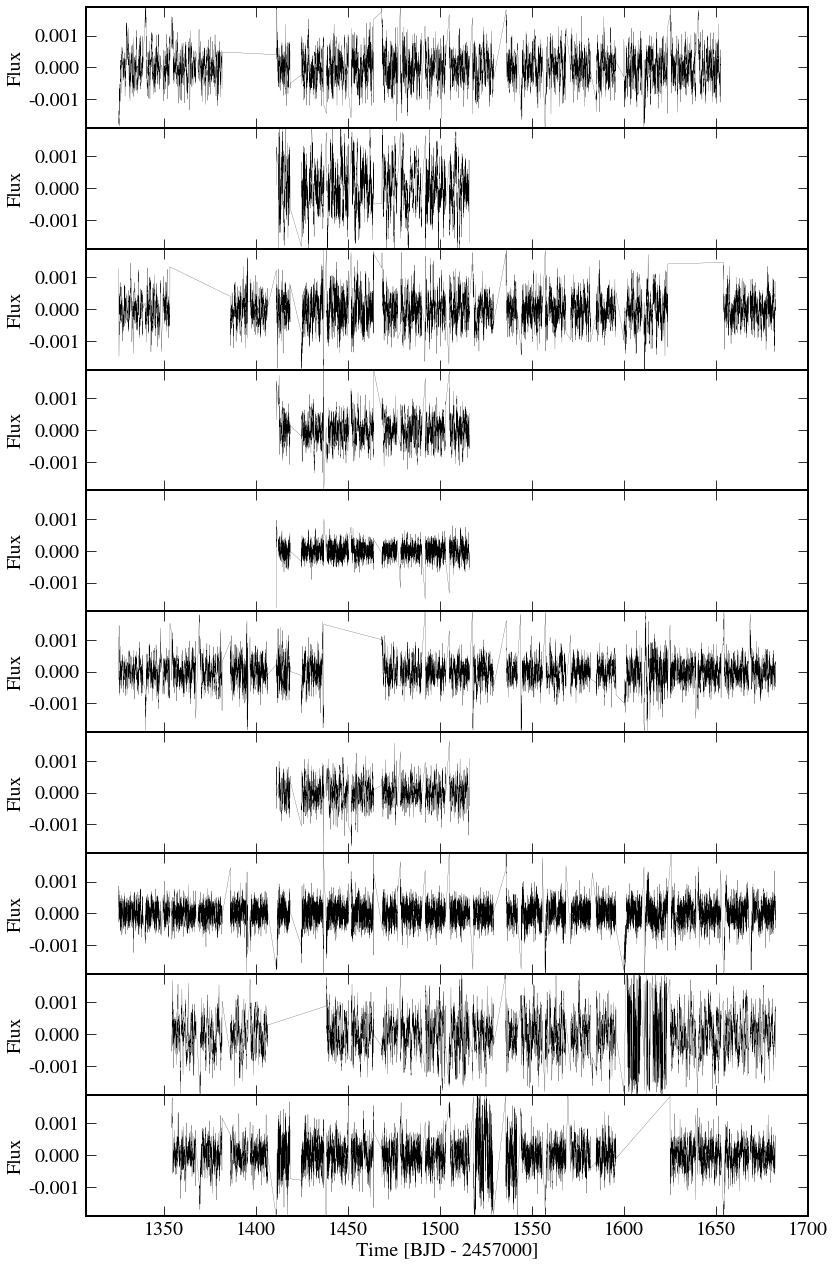

In [5]:
fig, ax = plt.subplots(10,1,figsize=(12,18), sharex=True, sharey=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(tm[i], fm[i], 'k-', lw=0.2)
    plt.ylabel('Flux')
    plt.ylim(-0.0019,0.0019)

plt.xlabel('Time [BJD - 2457000]')

plt.tight_layout(h_pad=0)

In [11]:
freq = np.linspace(0.1,60,2000)
fr = (freq/u.day).to(u.microhertz)

In [12]:
pgram = []

for i in range(10):
    p_ = signal.lombscargle(tm[i], fm[i], freq, normalize=True)
    pgram += [p_]

In [28]:
# find numax
numax = np.empty(10)*u.uHz
nutop = 60*u.uHz

for i in range(10):
    ind_max = np.argmax(pgram[i][fr<nutop])
    numax[i] = fr[fr<nutop][ind_max]

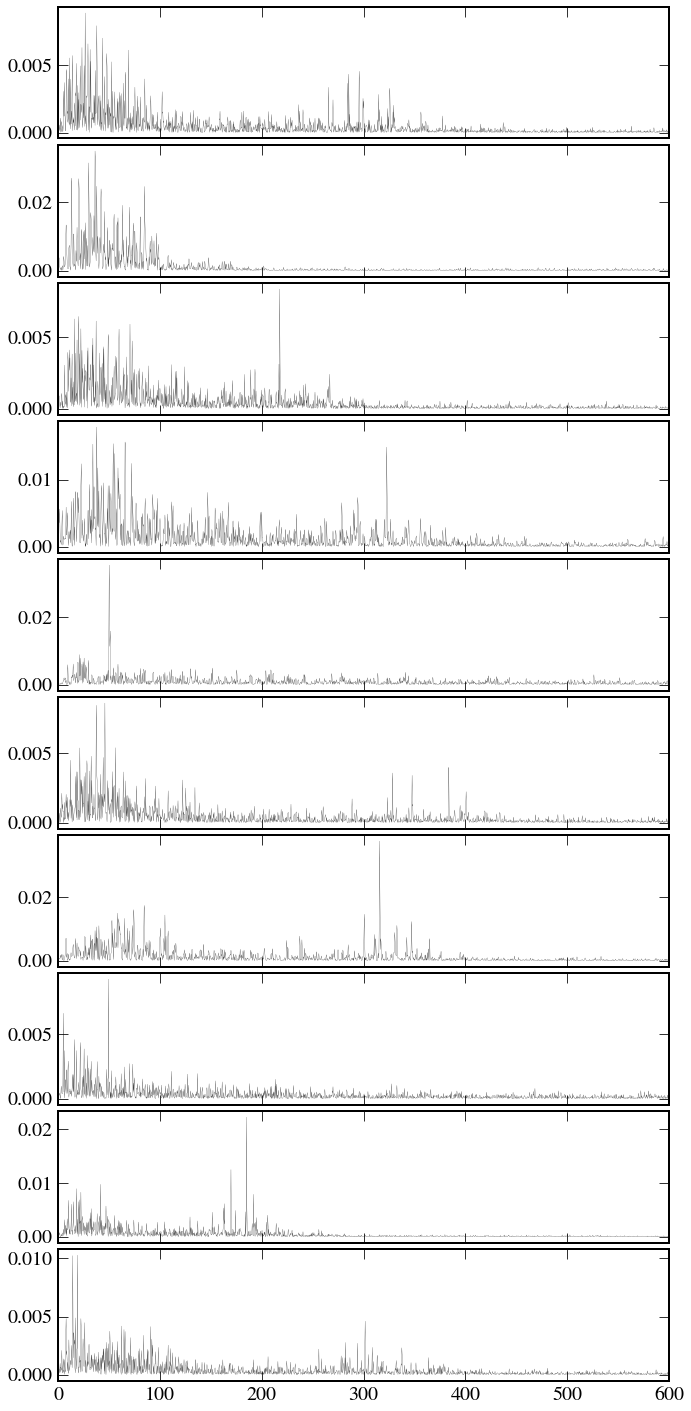

In [15]:
fig, ax = plt.subplots(10,1,figsize=(10,20), sharex=True)

for i in range(10):
    plt.sca(ax[i])
    plt.plot(fr, pgram[i], 'k-', lw=0.2)
    
plt.xlim(0,600)
plt.tight_layout(h_pad=0)

In [16]:
g = Table.read('../data/giants.fits')

In [17]:
distance = 1/g['parallax'] * u.kpc / u.mas
dm = 5*np.log10(distance.to(u.pc).value) - 5
G = g['phot_g_mean_mag'] - dm
G0 = G - np.nanmedian(g['a_g_val'])
# G0 = G - g['a_g_val']

/usr/lib64/python3.6/site-packages/numpy/lib/function_base.py:3523: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  part.partition(kth)


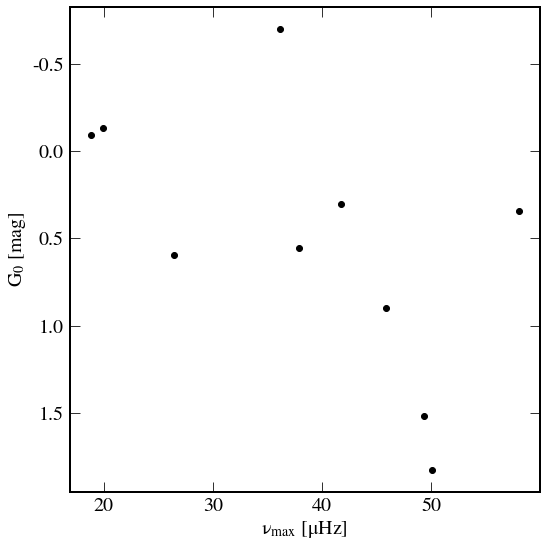

In [29]:
plt.plot(numax, G0[:10], 'ko')

plt.gca().invert_yaxis()
# plt.gca().set_xscale('log')
plt.xlabel('$\\nu_{max}$ [$\mu$Hz]')
plt.ylabel('G$_0$ [mag]')
plt.tight_layout()